# CMIP6 Arctic Case Study : Compute the aerosol-cloud interaction effective radiative forcing

--- 

## What this notebook holds :

---

<span style="color:red">**It is recommended to first run the *get_cmip6_data.ipynb* notebook to download and prepare the raw model's outputs data for the analysis.**</span>

This notebook aims at showing the effective radiative forcing that is caused by the aerosol burdens' levels of 2014 in the shortwave. It aims at evaluating the different components of the aerosol-cloud's interaction impact on the Arctic warming. This is done using a subset of the CMIP6 model ensemble and using the APRP method devised by *Taylor and al. (2007)* and whose implementation was done by *Zelinka and al. (2023)*. 

The subset used is described in the github repository and is the one used by *Zelinka and al.*. It can be found in details in the *load_cmip6* submodule as the case described by *ZELINKA-SW* in the *set_search_criterias* function. 

### The use of CMIP6 data

We use two experiments realized during the CMIP6  : **piClim-control** and **piClim-aer**. These are both atmosphere-only climate model simulations in which sea surface temperatures (SSTs) and sea icea concentrations (SICs) are fixed at model-specific preindustrial climatological values. The description of the experiments can be found here : https://wcrp-cmip.github.io/CMIP6_CVs/docs/CMIP6_experiment_id.html. On the one hand, the **piClim-control** realization assumes aerosols burdens set to their preindustrial levels hence why it is dubbed as the control experiment. On the other hand, the **piClim-aer** realization uses present-day, present-day being 2014, aerosols burdens' levels.

The variable used are listed and explicited below according to : https://clipc-services.ceda.ac.uk/dreq/mipVars.html. All the variables are monthly timeseries over 30 years. We use the monthly climatology of each of these variables.

> <span style="color:SkyBlue">**clt**</span>  : Total cloud area fraction (%) for the whole atmospheric column
>
> <span style="color:gold">**rsdt**</span> : Shortwave radiation ($W/m^{2}$) **incident** at the TOA
> 
> <span style="color:orange">**rsut**</span> : Shortwave radiation ($W/m^{2}$) **going out**  at the TOA
>
> <span style="color:orangered">**rsutcs**</span> : Shortwave radiation ($W/m^{2}$) **going out**  at TOA for **clear-sky conditions**
> 
> <span style="color:Orchid">**rsds**</span> : Shortwave **downwelling** radiation ($W/m^{2}$) at the surface
> 
> <span style="color:Indigo ">**rsdscs**</span>  : Shortwave **downwelling** radiation ($W/m^{2}$) at the surface for **clear-sky conditions**
> 
> <span style="color:YellowGreen">**rsus**</span> : Shortwave **upwelling** radiation ($W/m^{2}$) at the surface
>
> <span style="color:Darkgreen">**rsuscs**</span>: Shortwave **upwelling** radiation ($W/m^{2}$) at the surface for **clear-sky conditions**
>
> **areacella** : For every grid, the latitude-dependent surface associated to each grid point.

### Approximate Partial Radiative Perturbation

**TO WRITE...**

## References : 

### APRP method

Taylor, K. E., M. Crucifix, P. Braconnot, C. D. Hewitt, C. Doutriaux, A. J. Broccoli, J. F. B. Mitchell, and M. J. Webb, 2007: Estimating Shortwave Radiative Forcing and Response in Climate Models. J. Climate, 20, 2530–2543, https://doi.org/10.1175/JCLI4143.1. 

### APRP module used for our analysis

https://github.com/mzelinka/aprp

Zelinka, M. D., Smith, C. J., Qin, Y., and Taylor, K. E.: Comparison of methods to estimate aerosol effective radiative forcings in climate models, Atmos. Chem. Phys., 23, 8879–8898, https://doi.org/10.5194/acp-23-8879-2023, 2023.

### Author

Giboni Lucas, 1st year PhD Candidate at IGE (CNRS), Grenoble.

https://github.com/gibonil/gibonil

### License

Feel free to share, use and improve the following code according to the provided license on the repository.

---

# Initialisation

---

## Importations

We import the needed libraries

In [1]:
# ================ IMPORTATIONS ================ #

### LOAD AND NAVIGATE THROUGH THE DATA ###

import os  # to get access to commands related to path setting and creation of directories

### DATA OBJECTS AND ASSOCIATED COMPUTATION ###

import numpy as np  # to handle numpy arrays and the associated tools

import xarray as xr  # to manage the data

import xcdat as xc  # to handle climate model outputs with xarray

### REPRESENTING DATA ###

import matplotlib.pyplot as plt  # to handle plotting routines

import cartopy.crs as ccrs  # to handle map projections

### HOMEMADE LIBRARIES ###

## Load the climatology dictionary ##

from utilities.get_cmip6_data.store_data.dict_netcdf_transform import (
    netcdf_to_dict, # to load the climatology dictionary
)  

## Handle the climatology dictionary ##

from utilities.tools_for_analysis.handle_entries.extract_entries_names import (
    get_entries_only_from_clim_dict, # to add extract the entries' names
)

## Retrieve all the entries' names without the corresponding experiment ##

from utilities.get_cmip6_data.prepare_data.extract_climatologies import (
    add_one_variable_to_dataset, # to add one variable to the full dataset
)

## Generate a common grid on which we will regrid all CMIP6 outputs ##

from utilities.tools_for_analysis.regridding.regridding_methods import(
    generate_the_common_coarse_grid, # to create the common coarse grid 
    regridding_a_dictionary, # to regrid the aprp dictionary
)

## Extract only one variant's model output ##

from utilities.tools_for_analysis.handle_entries.extract_one_variant_per_model import (
    extract_only_one_variant_keys_list, # generates the keys' list with only one variant per source id
)

### APRP LIBRARY ###

from utilities.aprp.code.aprp import(
    APRP, # APRP method
)

### Define the paths for saving and loading data

In this part, the user needs to define the paths at which will be downloaded the data and saved the climatologies if necessary. They also need to define the path to the table associating the monthly climatologies netcdf files with their respective key in the climatologies' dictionary to be loaded. These paths are the absolute paths from the home directory.

If *get_cmip6_data.ipynb* notebook was run before, then only the path to the *key_paths_table.pkl* file is relevant here.

In [2]:
# ================ DEFINE THE FOLDERS WHERE IS STORED THE DATA ================ #

### DEFINE THE HOME DIRECTORY ###

## Home directory ##

homedir_path = os.path.expanduser("~")

### DEFINE WHERE TO DOWNLOAD THE RAW DATA ###

## Parent directory of the download folder ##

parent_path_download = homedir_path + "/certainty-data"

## Name of the download folder ##

download_folder_name = "CMIP6-DATA"

### DEFINE WHERE TO SAVE THE CLIMATOLOGIES ###

## Path of the save directory ##

parent_path_save_clim = (
    homedir_path + "/certainty-data/" + download_folder_name + "/climatologies"
)

### DEFINE WHERE TO LOOK FOR THE TABLE OF THE CLIMATOLOGIES' PATHS ###

table_path = parent_path_save_clim + "/table" + "/key_paths_table.pkl"

## Load the CMIP6 climatology

We load the CMIP6 climatology. We first check the existence of the *key_paths_table.pkl* file that indicate that the *get_cmip6_data.ipynb* notebook was successfully run. Otherwise, we launch the full routine to download the raw data and generate the climatologies. 

**This full routine lasts about 2 hours if no download was done before.**

Sometimes the data cannot be found for the downloading phase even though the entry was found in the search phase... The user will need to relaunch the code as it is an error linked to the connection to the servers.

In [3]:
# ================ LOAD THE MONTHLY CLIMATOLOGIES ================ #

### CHECK IF THE CLIMATOLOGIES WERE GENERATED BEFORE ###

if os.path.lexists(path = table_path) :

    ## The table exists we can therefore load the dictionary of the climatologies ## 

    print("The monthly climatologies were generated and can be retrieved.")

    data_cmip6_clim = netcdf_to_dict(parent_path_for_save = parent_path_save_clim)

else :

    ## The table does not exist : we need to download the data and prepare it ##

    print("No key_paths_table.pkl at the given path.\n" \
    "We download the data and create the monthly climatologies dictionary.")

    # We import the necessary submodule #

    from utilities.get_cmip6_data.prepare_data.extract_climatologies import (
    create_climatology_dict,  # to create the climatology dictionary and save it
    )

    ## Create the climatologies dictionary ##

    create_climatology_dict(
        data_path = parent_path_download,
        data_folder_name = download_folder_name,
        parent_path_for_save = parent_path_save_clim,
        selected_case = "ZELINKA-SW",
        do_we_clear = True,
        verbose = False,
    )

    ## Load it ##

    data_cmip6_clim = netcdf_to_dict(parent_path_for_save = parent_path_save_clim)

The monthly climatologies were generated and can be retrieved.


## Apply the Approximate Partial Radiative Perturbation computation to our dictionary

### Generate the APRP dictionary

Before applying the APRP function we have to be able to call both the **control** and **aer** xarray datasets for a given entry. This is why we start by generating the list of the dictionary keys without the experiments.

In [4]:
# ================ GET THE KEYS WITHOUT THE EXPERIMENT REFERENCE ================ #

### GENERATE THE KEYS WITHOUT THE EXPERIMENT ###

## Copy the list of the keys of the clim dictionary ##

clim_keys = list(data_cmip6_clim.keys())

## Generate the unique list of keys without the reference to the experiments ##

clim_keys_without_exp = [
    get_entries_only_from_clim_dict(key_with_exp) for key_with_exp in clim_keys
]

We apply the APRP method.

In [5]:
dict_aprp = {}

for key in clim_keys_without_exp:

    key_control = key + ".piClim-control"

    key_aer = key + ".piClim-aer"

    data_cmip6_clim[key_control].load()

    data_cmip6_clim[key_aer].load()

    output = APRP(data_cmip6_clim[key_control], data_cmip6_clim[key_aer])

    dict_aprp[key] = output

---

## Regrid the dictionary entries on a common coarser grid

---

### Creating a common coarser grid for all CMIP6 outputs

In order to be able to compare the different results, we wish to project them on a common map. This map needs to be coarser than all the natives grid in order to not generate false signals but still needs to be close enough to their original resolution. The solution that was found here is to generate the coarsest grid steps for latitude and longitude from the ensemble and generate a regular grid from them.

In [6]:
common_coarse_grid = generate_the_common_coarse_grid(dict_aprp)

### Regrid the entries

We now proceed to the regridding of the full dictionary.

In [7]:
### FIELDS THAT WE REGRID ###

fields_to_be_regridded = [
    'cld',
    'sfc_alb',
    'sfc_alb_clr',
    'sfc_alb_oc',
    'noncld',
    'noncld_scat',
    'noncld_abs',
    'cld_amt',
    'cld_scat',
    'cld_abs'
    ]

### REGRIDDING ROUTINE ###

dict_aprp_regridded = regridding_a_dictionary(
    fields_to_be_regridded = fields_to_be_regridded,
    output_grid = common_coarse_grid,
    dictionary_to_be_regridded = dict_aprp
)

Initialize with one variable...



Regridding all the variables...: 100%|██████████| 9/9 [01:09<00:00,  7.73s/it]


Adding areacella...

Done !


In [8]:
# needed for the concat function to work

dict_aprp_regridded_time_avg = {
    key: dict_aprp_regridded[key]
    .groupby(dict_aprp_regridded[key].time.dt.month)
    .mean().mean("month")
    for key in dict_aprp_regridded.keys()
}

keys_aprp = list(dict_aprp_regridded.keys())

In [9]:
def create_list_of_spatial_averaged_variables_for_given_entry(dataset : xr.Dataset) -> list[float]:

    plot_list_avg = [
    (dataset.spatial.average("cld", axis=["X", "Y"])["cld"] + dataset.spatial.average("noncld", axis=["X", "Y"])["noncld"]).values, # SW ERF ARI + ACI
    (dataset.spatial.average("noncld", axis=["X", "Y"])["noncld"]).values, # SW ERF ARI
    (dataset.spatial.average("cld", axis=["X", "Y"])["cld"]).values, # SW ERF ACI
    (dataset.spatial.average("sfc_alb", axis=["X", "Y"])["sfc_alb"]).values, # DELTA ALBED SURF
    ]

    return plot_list_avg


used to make zelinka's plots

In [10]:
keys_aprp = list(dict_aprp.keys())

reduced_list = extract_only_one_variant_keys_list(keys_aprp)

In [11]:
dict_aprp_reduced = {
    key : dict_aprp[key]
    for key in reduced_list
}

In [12]:
# make the average list

dict_aprp_before_regridding = {
    key: dict_aprp_reduced[key]
    .groupby(dict_aprp_reduced[key].time.dt.month)
    .mean().mean('month')
    for key in dict_aprp_reduced.keys()
}

In [13]:
# needed for the concat function to work

dict_aprp_regridded_time_avg = {
    key: dict_aprp_regridded[key]
    .groupby(dict_aprp_regridded[key].time.dt.month)
    .mean().mean("month")
    for key in dict_aprp_reduced.keys()
}

In [14]:
def adapt_for_spatial_avgd(DS : xr.Dataset) -> xr.Dataset :
    DS.lat.attrs["axis"] = "Y"
    DS.lon.attrs["axis"] = "X"
    DS = DS.bounds.add_missing_bounds()

    return DS


In [15]:
dict_aprp_regridded_time_avg= {
    key: adapt_for_spatial_avgd(dict_aprp_regridded_time_avg[key])
    for key in dict_aprp_reduced.keys()
}

In [16]:


list_avgd_variables_for_all_entries = [
    create_list_of_spatial_averaged_variables_for_given_entry(dict_aprp_regridded_time_avg[key])
    for key in dict_aprp_reduced.keys()
]

# adding gfdl esm4 (missing) from zelinka's results
list_avgd_variables_for_all_entries.append([-0.55, +0.09, -0.64, np.nan])

In [17]:
res_to_show = np.round(np.nanmean(list_avgd_variables_for_all_entries, axis = 0), 2)

In [18]:
res_to_show

array([-1.27, -0.26, -1.01, -0.03])

In [19]:
# let's make the entry average

ensemble_aprp_avg = xr.concat(dict_aprp_regridded_time_avg.values(), "entry").mean(
    dim="entry"
)



## Make a table for the Arctic 

In [20]:

dict_aprp_time_avg_arctic = {
    key: dict_aprp_regridded_time_avg[key].sel(lat = slice(60, 90))
    for key in reduced_list
}

In [21]:
def spatial_average_given_field(field : str, ds):

    spatial_avg = ds.spatial.average(field, axis=["X", "Y"])[field].values

    return np.round(spatial_avg, 2)

In [22]:
def compute_needed_spatial_avg_for_tables(key : str, ds : xr.Dataset):

    noncld_scat = spatial_average_given_field(field = "noncld_scat", ds = ds)

    noncld_abs = spatial_average_given_field(field = "noncld_abs", ds = ds)

    sum_ari = noncld_scat + noncld_abs

    dict_ari = {key :
                {
        'scat' : noncld_scat,
        'abs' : noncld_abs,
        'sum' : sum_ari,
                }
    }
    cld_scat = spatial_average_given_field(field = "cld_scat", ds = ds)

    cld_abs = spatial_average_given_field(field = "cld_abs", ds = ds)

    cld_amt = spatial_average_given_field(field = "cld_amt", ds = ds)

    sum_aci = cld_scat + cld_abs + cld_amt

    dict_aci = { 
        key : {
        'scat' : cld_scat,
        'abs' : cld_abs,
        'cld_amt' : cld_amt,
        'sum' : sum_aci,
        }
    }

    
    sum_aci_ari = sum_aci + sum_ari

    dict_sum_aci_ari = {
        key : {
            "ACI + ARI " : sum_aci_ari
        }
    }
    return dict_ari, dict_aci, dict_sum_aci_ari

In [23]:
import pandas as pd

In [24]:
dict_aprp_regridded_time_avg.keys()

dict_keys(['ACCESS-CM2.r1i1p1f1.gn', 'ACCESS-ESM1-5.r1i1p1f1.gn', 'BCC-ESM1.r1i1p1f1.gn', 'CESM2.r1i1p1f1.gn', 'CNRM-CM6-1.r1i1p1f2.gr', 'CNRM-ESM2-1.r1i1p1f2.gr', 'CanESM5.r1i1p2f1.gn', 'GFDL-CM4.r1i1p1f1.gr1', 'GISS-E2-1-G.r1i1p1f1.gn', 'HadGEM3-GC31-LL.r1i1p1f3.gn', 'IPSL-CM6A-LR.r1i1p1f1.gr', 'IPSL-CM6A-LR-INCA.r1i1p1f1.gr', 'MIROC6.r11i1p1f1.gn', 'MPI-ESM-1-2-HAM.r1i1p1f1.gn', 'MRI-ESM2-0.r1i1p1f1.gn', 'NorESM2-LM.r1i1p1f1.gn', 'NorESM2-MM.r1i1p1f1.gn', 'UKESM1-0-LL.r1i1p1f4.gn'])

In [48]:
key_00 = reduced_list[0]

dict_ari, dict_aci, dict_sum_aci_ari = compute_needed_spatial_avg_for_tables(key = key_00, ds = dict_aprp_time_avg_arctic[key_00])

df1 = pd.DataFrame.from_dict(dict_ari)

df2 = pd.DataFrame.from_dict(dict_aci)

df3 = pd.DataFrame.from_dict(dict_sum_aci_ari)

dict_to_be_dfd = {'ARI' : df1, 'ACI' : df2, '' : df3}

main_df = pd.concat(dict_to_be_dfd).T

for key in reduced_list[1:] :

    dict_ari, dict_aci, dict_sum_aci_ari = compute_needed_spatial_avg_for_tables(key = key, ds = dict_aprp_time_avg_arctic[key])

    df1 = pd.DataFrame.from_dict(dict_ari)

    df2 = pd.DataFrame.from_dict(dict_aci)

    df3 = pd.DataFrame.from_dict(dict_sum_aci_ari)

    dict_to_be_dfd = {'ARI' : df1, 'ACI' : df2, '' : df3}

    df = pd.concat(dict_to_be_dfd).T

    main_df = pd.concat([main_df, df])

In [49]:
main_df = main_df.sort_index()


mean = main_df.median(skipna = True)

std = main_df.std(skipna = True)

main_df

ARI               ACI                      \
                               scat   abs   sum  scat   abs cld_amt   sum   
ACCESS-CM2.r1i1p1f1.gn        -0.71  0.45 -0.26 -0.54  0.07   -0.27 -0.74   
ACCESS-ESM1-5.r1i1p1f1.gn     -0.11  0.49  0.38 -0.46  0.01   -0.15 -0.60   
BCC-ESM1.r1i1p1f1.gn          -0.64  0.03 -0.61 -0.81 -0.08   -0.20 -1.09   
CESM2.r1i1p1f1.gn             -0.16  0.41  0.25 -1.42  0.20   -0.15 -1.37   
CNRM-CM6-1.r1i1p1f2.gr        -0.20  0.06 -0.14 -0.33 -0.05    0.07 -0.31   
CNRM-ESM2-1.r1i1p1f2.gr       -0.17  0.14 -0.03 -0.10 -0.04   -0.00 -0.14   
CanESM5.r1i1p2f1.gn           -0.88  1.54  0.66 -0.71  0.13   -0.30 -0.88   
GFDL-CM4.r1i1p1f1.gr1         -0.59  0.66  0.07 -0.32  0.04   -0.21 -0.49   
GISS-E2-1-G.r1i1p1f1.gn       -0.73  0.10 -0.63  0.32  0.11   -0.57 -0.14   
HadGEM3-GC31-LL.r1i1p1f3.gn   -0.70  0.39 -0.31 -0.42  0.05   -0.26 -0.63   
IPSL-CM6A-LR-INCA.r1i1p1f1.gr -0.45  0.19 -0.26 -0.01 -0.06   -0.27 -0.34   
IPSL-CM6A-LR.r1i1p1f1.gr      -0.35  0.15 -0.20  0.06 -0.05    0.06  0.07   
MIROC6.r11i1p1f1.gn           -0.33 -0.01 -0.34 -0.42 -0.01   -0.11 -0.54   
MPI-ESM-1-2-HAM.r1i1p1f1.gn    0.12  0.05  0.17 -0.37  0.00   -0.16 -0.53   
MRI-ESM2-0.r1i1p1f1.gn        -0.43  0.11 -0.32 -0.52 -0.06   -0.12 -0.70   
NorESM2-LM.r1i1p1f1.gn        -0.30  0.32  0.02 -1.47 -0.07   -0.09 -1.63   
NorESM2-MM.r1i1p1f1.gn        -0.28  0.35  0.07 -1.65  0.06   -0.39 -1.98   
UKESM1-0-LL.r1i1p1f4.gn       -0.66  0.56 -0.10 -0.68  0.07   -0.30 -0.91   

                                          
                              ACI + ARI   
ACCESS-CM2.r1i1p1f1.gn             -1.00  
ACCESS-ESM1-5.r1i1p1f1.gn          -0.22  
BCC-ESM1.r1i1p1f1.gn               -1.70  
CESM2.r1i1p1f1.gn                  -1.12  
CNRM-CM6-1.r1i1p1f2.gr             -0.45  
CNRM-ESM2-1.r1i1p1f2.gr            -0.17  
CanESM5.r1i1p2f1.gn                -0.22  
GFDL-CM4.r1i1p1f1.gr1              -0.42  
GISS-E2-1-G.r1i1p1f1.gn            -0.77  
HadGEM3-GC31-LL.r1i1p1f3.gn        -0.94  
IPSL-CM6A-LR-INCA.r1i1p1f1.gr      -0.60  
IPSL-CM6A-LR.r1i1p1f1.gr           -0.13  
MIROC6.r11i1p1f1.gn                -0.88  
MPI-ESM-1-2-HAM.r1i1p1f1.gn        -0.36  
MRI-ESM2-0.r1i1p1f1.gn             -1.02  
NorESM2-LM.r1i1p1f1.gn             -1.61  
NorESM2-MM.r1i1p1f1.gn             -1.91  
UKESM1-0-LL.r1i1p1f4.gn            -1.01

In [50]:
mean.round(2)

ARI  scat         -0.39
     abs           0.26
     sum          -0.12
ACI  scat         -0.44
     abs           0.00
     cld_amt      -0.18
     sum          -0.62
     ACI + ARI    -0.82
dtype: float64

In [51]:
iqr_arctic = np.abs(main_df.quantile(q = 0.95) - main_df.quantile(q = 0.05))

## Antarctic ##

quartile95_arctic = main_df.quantile(q = 0.95).round(2)


### 5% ###

## Global ##

quartile5_arctic = main_df.quantile(q = 0.05).round(2)


## PLOT MAP OF APRP COMPONENTS

In [52]:
# needed for the concat function to work

dict_aprp_regridded_time_avg = {
    key: dict_aprp_regridded[key]
    .groupby(dict_aprp_regridded[key].time.dt.month)
    .mean()
    for key in reduced_list
}


In [53]:
### COMPUTE TIME AVERAGE ###

## Generate a dictionary of the regridded APRP maps averaged over time ##

dict_aprp_time_avg = {
    key: dict_aprp_regridded[key]
    .groupby(dict_aprp[key].time.dt.month) # we already have monthly climatologies but this way we simplify the time coordinate into into a "month" coordinate
    .mean().mean("month") # average over time
    for key in reduced_list
}

In [54]:
### MAKING THE ENTRY AVERAGES TO GENERATE A MEAN MAP ###

ensemble_aprp_avg = xr.concat(dict_aprp_time_avg.values(), "entry").mean(
    dim="entry"
)

In [55]:
import matplotlib.pyplot as plt # used for makings nice plots

import matplotlib.dates as mdates # used to show months in a plot legend

import matplotlib.colors as colors # used to linearly interpolate uneven colorbars

import matplotlib.path as mpath # used to handle the polar circle

from cartopy.util import add_cyclic_point # to have nice contours plot on the earth's map


IndexError: list index out of range

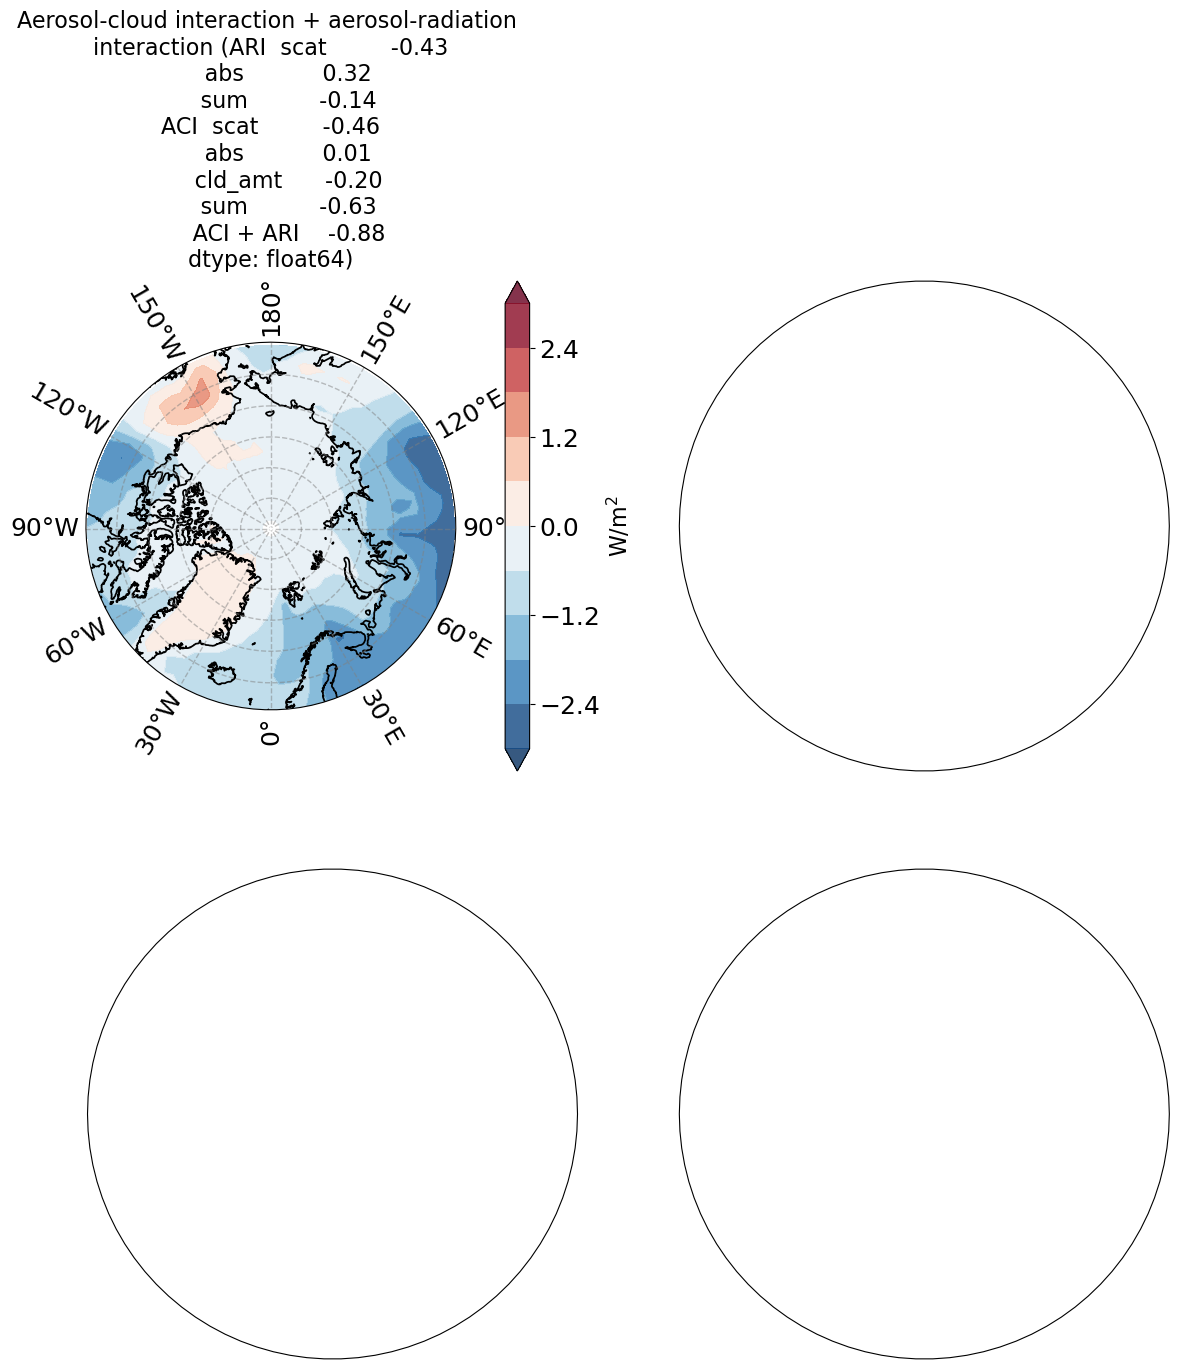

In [46]:
output = ensemble_aprp_avg.sel(lat = slice(60, 90))

# Define the figure and each axis for the 2 rows and 2 columns #

nrows = 2

ncols = 2

# Define the figure #

fig, axes = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.NorthPolarStereo()},
                        figsize=(14,14),edgecolor='k')

cnt = -1

avgmap = output

plot_list_avg = [mean
                 ]
"""
[
    (avgmap.spatial.average("cld", axis=["X", "Y"])["cld"] + avgmap.spatial.average("noncld", axis=["X", "Y"])["noncld"]).values, # SW ERF ARI + ACI
    (avgmap.spatial.average("noncld", axis=["X", "Y"])["noncld"]).values, # SW ERF ARI
    (avgmap.spatial.average("cld", axis=["X", "Y"])["cld"]).values, # SW ERF ACI
    (avgmap.spatial.average("sfc_alb", axis=["X", "Y"])["sfc_alb"]).values, # DELTA ALBED SURF
]
"""

plot_list_map = [
    (avgmap["cld"] + avgmap["noncld"]), # SW ERF ARI + ACI
    (avgmap["noncld"]), # SW ERF ARI
    (avgmap["cld"]), # SW ERF ACI
    (avgmap["sfc_alb"]), # DELTA ALBED SURF
]
"""
list_titles = [
        "SW $ERF_{aci + ari}$",
        "SW $ERF_{ari}$",
        "SW $ERF_{aci}$",
        "$\\Delta ERF_{alb}$"
]"""

list_titles = [
        "Aerosol-cloud interaction + aerosol-radiation \ninteraction",
        "Aerosol-radiation interaction",
        "Aerosol-cloud interaction",
        "Albedo change"
]

cbar_ticks_list = []

contours_lev_1 = np.arange(-3, 3.6, 0.6)

norm_1 = colors.TwoSlopeNorm(vcenter = 0, vmin = -3, vmax = 3)

cbar_ticks_list.append([contours_lev_1,norm_1])


# Third plot #

contours_lev_2 = np.arange(-0.5, 0.5, 0.1)

norm_2 = colors.TwoSlopeNorm(vcenter = 0, vmin = -0.5, vmax = 0.5)

# there is a norm because we center on 0

cbar_ticks_list.append([contours_lev_2, norm_2])

# Second plot #

contours_lev_3 =  np.arange(-3, 3.6, 0.6)

norm_3 = colors.TwoSlopeNorm(vcenter = 0, vmin = -3, vmax = 3)

# there is a norm because we center on 0

cbar_ticks_list.append([contours_lev_3,norm_3])

# Fourth plot #

n_ticks_4 = 10

contours_lev_4 = np.arange(-0.6, 0.8, 0.2)

norm_4 = colors.TwoSlopeNorm(vcenter = 0, vmin = -0.6, vmax = 0.6)

# there is a norm because we center on 0

cbar_ticks_list.append([contours_lev_4, norm_4])

cbar_ticks_list.append(contours_lev_4)



for row in range(2):
        for cl in range(2):
        
            cnt += 1

            avg = plot_list_avg[cnt]

            flux_for_chosen_month, lons = add_cyclic_point(plot_list_map[cnt].values, coord=plot_list_map[cnt].lon.values)

            cmap = 'RdBu_r'

            if cnt == 3:
                # albedo

                cmap = 'RdBu'
                
            cs = axes[row,cl].contourf(lons, plot_list_map[cnt].lat.values, flux_for_chosen_month, cbar_ticks_list[cnt][0],
                          transform = ccrs.PlateCarree(),
                          cmap=cmap,alpha=0.8, extend='both', norm = cbar_ticks_list[cnt][1])
            

            axes[row,cl].set_title(list_titles[cnt] + " (" + str(np.round(avg,2)) + ")", fontsize = 16)

            # Set the map extent for each subplot (Arctic circle) #

            axes[row,cl].set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
            
            # Adding gridlines and labels for each subplot #
            
            axes[row,cl].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, \
                            xlocs=range(-180,180,30), ylocs=[], \
                            color='gray', alpha=0.5, linestyle='--')
                
            # for the longitude
            
            axes[row,cl].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, \
                            xlocs=[], ylocs=None, \
                            color='gray', alpha=0.5, linestyle='--')

            # for the latitude no label

            # Draw the coastines for each subplot #
                
            axes[row,cl].coastlines(linewidth=1.25)
            
            
            ## Circular limits ##

            # Define circular limits #
                
            theta = np.linspace(0, 2 * np.pi, 100)
            
            centre, radius = [0.5, 0.5], 0.5
            
            verts = np.vstack([np.sin(theta), np.cos(theta)]).T
            
            circle = mpath.Path(verts * radius + centre)
                
            # Apply the circular limits #
                
            axes[row,cl].set_boundary(circle, transform=axes[row,cl].transAxes)

            cbar = fig.colorbar(cs, ax=axes[row,cl],orientation='vertical',pad = 0.1)

            
            cbar.ax.set_ylabel("W/m$^2$",fontsize = 16)
        
            
            ## Contour plot ##

# room for colorbar 
# (left, bottom, width, height) 




# , pad=3, , aspect=15,

# Make everything hold together nicely #



# Make room for a suptitle with the correct month name #

plt.subplots_adjust(top=0.8)

sup_title = "Maps and regional average of the Short Wave Effective Radiative Forcing\ncaused by 2014 aerosols' concentrations in the Arctic divided into different components"

# Define suptitle #

plt.suptitle(sup_title, fontsize = 18);

plt.tight_layout()

plt.savefig('rsut_clim_september.pdf', format = "pdf")

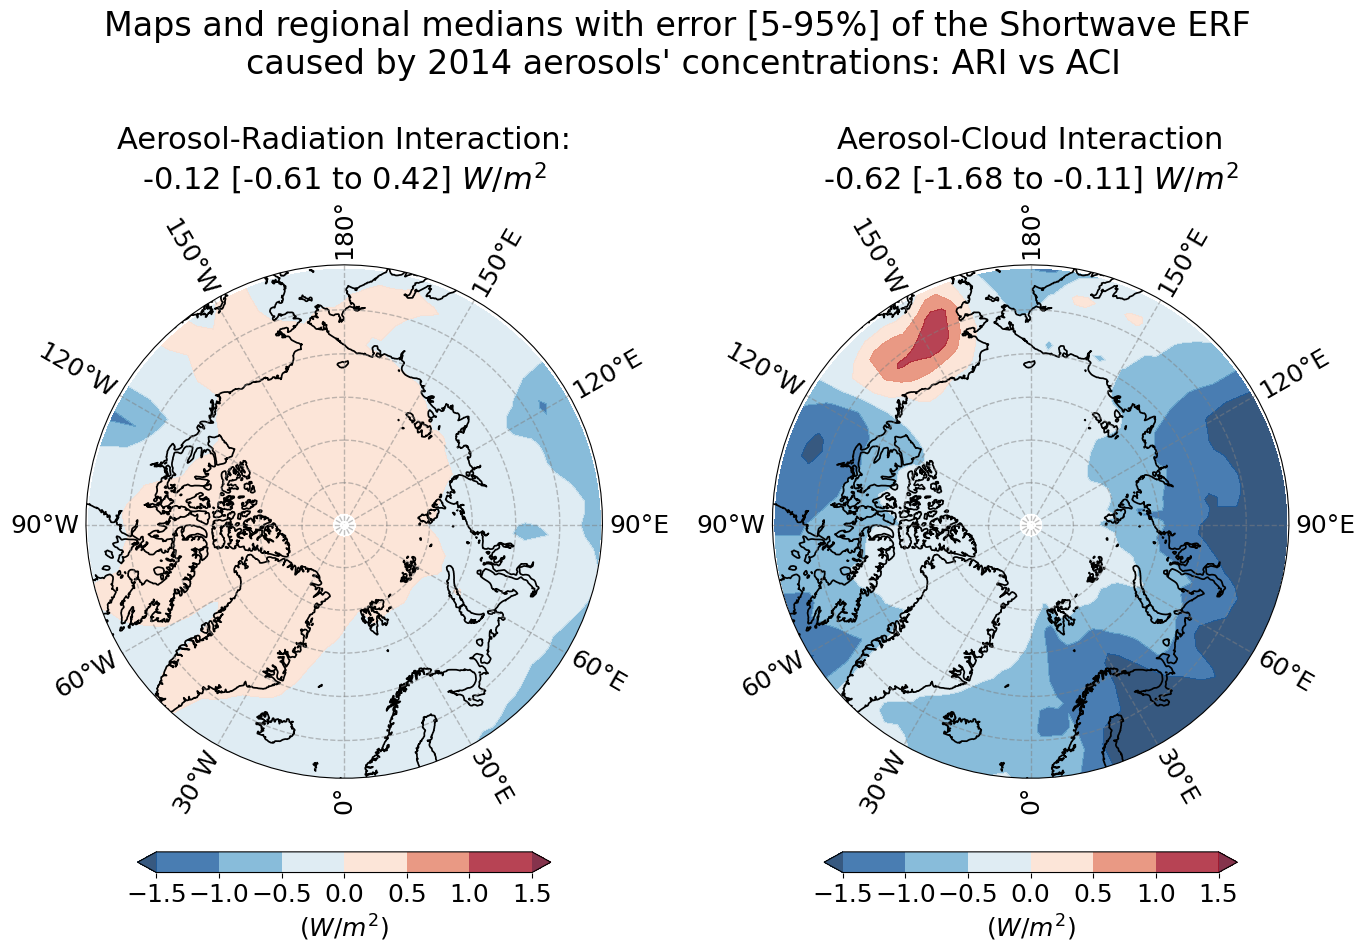

In [56]:
output = ensemble_aprp_avg.sel(lat = slice(60, 90))

plt.rcParams.update({'font.size': 18})

# Define the figure and each axis for the 2 rows and 2 columns #

nrows = 1

ncols = 2

# Define the figure #

fig, axes = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.NorthPolarStereo()},
                        figsize=(14,10),edgecolor='k')

cnt = -1

avgmap = output

plot_list_avg = [mean["ARI","sum"].round(2),
                 mean["ACI","sum"].round(2)]


plot_list_std = [std["ARI","sum"].round(2),
                 std["ACI","sum"].round(2)]
"""
[
    (avgmap.spatial.average("cld", axis=["X", "Y"])["cld"] + avgmap.spatial.average("noncld", axis=["X", "Y"])["noncld"]).values, # SW ERF ARI + ACI
    (avgmap.spatial.average("noncld", axis=["X", "Y"])["noncld"]).values, # SW ERF ARI
    (avgmap.spatial.average("cld", axis=["X", "Y"])["cld"]).values, # SW ERF ACI
    (avgmap.spatial.average("sfc_alb", axis=["X", "Y"])["sfc_alb"]).values, # DELTA ALBED SURF
]
"""

plot_list_map = [
    (avgmap["noncld"]), # SW ERF ARI
    (avgmap["cld"]), # SW ERF ACI
]
"""
list_titles = [
        "SW $ERF_{aci + ari}$",
        "SW $ERF_{ari}$",
        "SW $ERF_{aci}$",
        "$\\Delta ERF_{alb}$"
]"""

list_titles = [
        "Aerosol-Radiation Interaction:",
        "Aerosol-Cloud Interaction",
]

cbar_ticks_list = []

contours_lev_1 = np.arange(-1.5, 2, 0.5)

norm_1 = colors.TwoSlopeNorm(vcenter = 0, vmin = -1.5, vmax = 1.5)

cbar_ticks_list.append([contours_lev_1,norm_1])

contours_lev_2 = np.arange(-1.5, 2, 0.5)

norm_2 = colors.TwoSlopeNorm(vcenter = 0, vmin = -1.5, vmax = 1.5)

cbar_ticks_list.append([contours_lev_2,norm_2])


for row in range(2):
        
            cnt += 1

            axx = axes[row]

            avg = plot_list_avg[cnt]

            flux_for_chosen_month, lons = add_cyclic_point(plot_list_map[cnt].values, coord=plot_list_map[cnt].lon.values)

            cmap = 'RdBu_r'

                
            cs = axx.contourf(lons, plot_list_map[cnt].lat.values, flux_for_chosen_month, cbar_ticks_list[cnt][0],
                          transform = ccrs.PlateCarree(),
                          cmap=cmap,alpha=0.8, extend='both', norm = cbar_ticks_list[cnt][1])
            

            if row == 0 :

                axx.set_title(list_titles[cnt] + "\n" + str(plot_list_avg[cnt]) + f" [{quartile5_arctic.ARI["sum"]} to {quartile95_arctic.ARI["sum"]}] $W/m^{2}$", fontsize = 22)

            else : 
                    
                axx.set_title(list_titles[cnt] + "\n" + str(plot_list_avg[cnt]) + f" [{quartile5_arctic.ACI["sum"]} to {quartile95_arctic.ACI["sum"]}] $W/m^{2}$", fontsize = 22)

            # Set the map extent for each subplot (Arctic circle) #

            axx.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
            
            # Adding gridlines and labels for each subplot #
            
            axx.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, \
                            xlocs=range(-180,180,30), ylocs=[], \
                            color='gray', alpha=0.5, linestyle='--')
                
            # for the longitude
            
            axx.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, \
                            xlocs=[], ylocs=None, \
                            color='gray', alpha=0.5, linestyle='--')

            # for the latitude no label

            # Draw the coastines for each subplot #
                
            axx.coastlines(linewidth=1.25)
            
            
            ## Circular limits ##

            # Define circular limits #
                
            theta = np.linspace(0, 2 * np.pi, 100)
            
            centre, radius = [0.5, 0.5], 0.5
            
            verts = np.vstack([np.sin(theta), np.cos(theta)]).T
            
            circle = mpath.Path(verts * radius + centre)
                
            # Apply the circular limits #
                
            axx.set_boundary(circle, transform=axx.transAxes)

            cbar = fig.colorbar(cs, ax=axx,orientation='horizontal',pad = 0.1, shrink = 0.8)

            
            cbar.ax.set_xlabel("($W/m^2$)")
        
            
            ## Contour plot ##

# room for colorbar 
# (left, bottom, width, height) 



# , pad=3, , aspect=15,

# Make everything hold together nicely #



# Make room for a suptitle with the correct month name #

plt.subplots_adjust(top=0.8)

sup_title = "Maps and regional medians with error [5-95%] of the Shortwave ERF \ncaused by 2014 aerosols' concentrations: ARI vs ACI"

# Define suptitle #

plt.suptitle(sup_title, fontsize = 24);

plt.tight_layout()
